<a href="https://colab.research.google.com/github/CinderZhang/DataAnalytics/blob/main/insider_trading_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Insider Trading Analysis with Python

In this tutorial, we will explore how to use Python to scrape insider trading data from SEC Form 4 filings, and how to analyze the data.

We’ll start by talking about what Form 4 filings and insiders are, then move on to discussing how you can use Python to gather the data from SEC EDGAR filings. After that, we will use various Python libraries to perform some basic analysis on the gathered data to generate potential buy and sell indicators to copy and follow insider trading activity.

Our objective is to discover trading patterns that forecast stock price shifts. Two such examples are included as a preview below.

The time Elon Musk sold the first batch of his Tesla shares perfectly coincided with the peak of Tesla's share price in late 2021. Subsequent sales were also reasonably well timed.

![img](https://i.imgur.com/iXz5zen.png)


Buffet's Berkshire Hathaway purchased OXY shares totaling $9 billion in 2022 while perfectly timing the bottom of each retracement.

![img2](https://i.imgur.com/tSX8DlC.png)


Here is an another analysis that looks at share sales made in various sectors over different years, foreshadowing the tech sell-off in 2022 with the largest insider sales in tech in 2021 for last 10 years.

![img4](https://i.imgur.com/ffOmD8g.png)

<!-- ![img3](https://i.imgur.com/PjtglWX.png) -->


# Overview

We begin by constructing our local database of insider trades for the years 2012 to 2022. To do this, we utilize the [Insider Trading Data API from SEC-API.io](https://sec-api.io/docs/insider-ownership-trading-api). The process involves: 

1. Downloading Form 3, 4 and 5 filings which have been converted from XML to JSON
2. Extracting all insider transactions from the JSON filings
3. Cleaning transactions (e.g. removing incorrectly reported trades)
4. Augmenting transactions with sector and industry information
5. Analyzing the data

To ensure that we are on the same page, let's first define some terms before we move forward with our project.

---

# Basics & Definitions

## What is insider trading?

Insiders are famously known from movies such as Wall Street with Gordon Gekko jailed after making fortunes by trading on non-public information (aka insider information). Those types of insiders are not subject of this tutorial. We focus on the legal part of insider trading. 

The law defines the line between legal and illegal insider trading reasonably well. The reason I say "reasonably" is because there are still lots of holes in the rule framework that insiders use frequently to impeccably time the market (more on this later).

In order to understand the difference between legal and illegal trading, we start with Section 16 of the  Securities Exchange Act (SEA). Section 16 is a regulation that requires insiders to publicly disclose the trades in their companys' securities (stocks, options, etc.). Section 16 was first introduced in early 2000 and has been updated numerous times since. [The most recent change to Section 16 was published on December 29, 2022](https://www.govinfo.gov/content/pkg/FR-2022-12-29/pdf/2022-27675.pdf#page=69).

[Insiders are defined in Section 16a-2](https://www.ecfr.gov/current/title-17/chapter-II/part-240/subject-group-ECFR4594b28bbb3a5d5/section-240.16a-2) as follows:

> Any person and immediate family of such person who owns more than 10% of a company's securities ([includes trusts](https://www.ecfr.gov/current/title-17/chapter-II/part-240/subject-group-ECFR4594b28bbb3a5d5/section-240.16a-8#p-240.16a-8(a))), any director or officer of the issuer of such securities, and any member of an advisory board.

"Officer" means an issuer's president, financial officer, accounting officer, vice-president in charge of a principal business unit (such as sales, administration or finance), and any other officer who performs a policy-making function. Examples are CEO, CFO, COO, VP of sales, and chairman of the board.

An issuer is simply the company that issued the security. For example, Tesla is the issuer of TSLA stock.

All definitions of the terms and more details about related SEC filings can be found in [Part 240, General Rules and Regulations of the SEA](https://www.ecfr.gov/current/title-17/chapter-II/part-240).

> There are three other types of SEC filings disclosing trades in a public company, that is Form 13D, 13G and 13F. See details at the end of the tutorial. Such filings are not topic of the analysis.

In summary, Section 16 defines the disclosure framework of insider trades such as when and how many securities were purchased/sold, what types of securities were purchased/sold and who performed the transaction.

## Swing-Trading by Insiders 

[Section 16b](https://www.ecfr.gov/current/title-17/chapter-II/part-240/subject-group-ECFRc96807fa2565b1d#p-240.16b-6(c)) prevents insiders from performing profitable short-term swing trades and is also called the "short-swing profit rule". The regulation requires insiders to return to the company any profits made from the purchase/sale of company stock if both transactions occur within a six-month period.

## What is an insider trade?

It's simply a buy or sell order in the company's securities performed by an insider. It could be a sales of the company's stock, exercising options, or receiving additional stocks as part of a bonus payout.

## How is an insider trade reported?

Insider trades are disclosed on three different forms.

- Form 3 discloses the ownership after an IPO or other security registration events. It's only filed after the registration.
- Form 4 discloses the change of ownership and is filed every time a change (buy/sell) occurred. 
- Form 5 is an annual statement of ownership structure.

[Form 3, 4 and 5](https://www.ecfr.gov/current/title-17/chapter-II/part-240/subject-group-ECFR4594b28bbb3a5d5/section-240.16a-3) are published on the SEC EDGAR system as a HTML and XML document. For this tutorial, we use all three form types and the XML-to-JSON converted data of each filing type.

## When does an insider trade have to be reported with the SEC?

- [Form 3](https://www.ecfr.gov/current/title-17/chapter-II/part-240/subject-group-ECFR4594b28bbb3a5d5/section-240.16a-3#p-240.16a-3(a)) is filed during the period securities are initially registered, e.g. an IPO.
- [Form 4](https://www.ecfr.gov/current/title-17/chapter-II/part-240/subject-group-ECFR4594b28bbb3a5d5/section-240.16a-3#p-240.16a-3(g)(1)) is filed before the end of the second business day following the day on which the transaction has been executed.
- [Form 5](https://www.ecfr.gov/current/title-17/chapter-II/part-240/subject-group-ECFR4594b28bbb3a5d5/section-240.16a-3#p-240.16a-3(f)(1)) is filed within 45 days after the issuer's fiscal year end, and discloses the holdings and transactions not reported previously on Forms 3, 4 or 5.


## What is included in Form 4 and how is it structured?

Form 4 content always follows a standardized structure and includes:
- Information about the company: company name, ticker, CIK
- Information about the insider: name, position, relationship to the company (director, 10% owner, etc.)
- Transaction details:
	- Were securities acquired/disposed?
  - What type of securities were acquired/disposed (stocks, options, notes, warrants, etc.)?
	- How many securities acquired/disposed and at what price?
	- How many securities does the insider own after the transaction?
- Footnotes with full-text details about the transactions. For example, indicating that transactions fall under Rule 10b5-1.

The below figure depicts a Form 4 filing for one of Elon Musk's Tesla share sales in July 2022 ([source file on EDGAR](https://www.sec.gov/Archives/edgar/data/1318605/000089924322035393/xslF345X03/doc4.xml)). 

The yellow marked areas represent the most important details in Form 4 filings, that being the 
- reporting person (Musk), 
- issuer (Tesla), 
- transaction details (buy vs sell, amount of shares acquired/disposed and the price) 
- and footnotes. 

The owner of the security (Elon Musk) is called the **reporter**. 
The company (Tesla) that issued the securities is called the **issuer**.

Important to note is that some reporters state the total price paid for the entire transaction rather than the price per share. Elon correctly reported all his transactions on a price per share basis. However, we need to be aware of this confusion in order to adjust for such cases during the data cleaning process.

![img](https://i.imgur.com/blgo5iE.png)

## What are derivative vs. non-derivative transactions?

The Form 4 example above showed two tables, Table I listing non-derivative transactions and Table II holding derivative transactions. A non-derivative is the financial term for things we mostly call stocks, while derivatives represent things we know as options or futures.

![img](https://i.imgur.com/LBJNlDC.png)

## What is a 10b5-1 trading plan?

[Section 10b5-1](https://www.ecfr.gov/current/title-17/chapter-II/part-240/subpart-A/subject-group-ECFR71e2d22647918b0/section-240.10b5-1#p-240.10b5-1(b)) of the SEA makes it illegal for anyone (not only insiders) to trade on the basis of material nonpublic information. 

"[Material](https://www.law.cornell.edu/definitions/index.php?width=840&height=800&iframe=true&def_id=c9640e72263ad5d1d09ddc21586591d9&term_occur=999&term_src=Title:17:Chapter:II:Part:240:Subpart:A:Subjgrp:68:240.10b5-1)" just means that the information is highly likely to influence an investor's buy or sell decision. The change of a CEOs home address would be the opposite of material information.

When we refer to "insider information" or "nonpublic information", we always mean "material nonpublic information", for example a merger agreement the CEO knows about but that hasn't been announced yet.

Insiders always have access to nonpublic information, otherwise they wouldn't be classified as insiders. But insiders also like to buy and sell their stocks without performing a crime. 

So, how does the law solves this dilemma? By introducing exemptions from the rule, so called [affirmative defenses](https://www.ecfr.gov/current/title-17/chapter-II/part-240/subpart-A/subject-group-ECFR71e2d22647918b0/section-240.10b5-1#p-240.10b5-1(c)). In other words, an insider is allowed to trade his stock if he demonstrates that:

- Before becoming aware of the information, the insider had adopted a written plan for trading securities
- The plan specifies the amount of securities to be purchased/sold and the price at which and the date on which the securities were to purchased/sold
- The insider acted in accordance to the plan

This plan is often referred to as "rule 10b5-1 plan".

In other words, an insider is allowed to buy/sell securities at predefined periods of the year, but is not allowed to perform any orders outside of this trading calendar. If that happens, the trade is classified as illegal. 

The plans are voluntarily disclosed to the public, and have to be approved by the director/s of the company. The disclosure mostly happens via 8-K filings in "Item 8.01 Other Event". Most companies choose not to publish them for reasons we cover later.

The following is an example of a voluntary notification informing the public about the adoption of a 10b5-1 sales plan ([source filing](https://www.sec.gov/Archives/edgar/data/1140859/000114085922000115/abc-20221213.htm)).

![img](https://i.imgur.com/OgqDcZA.png)


If an insider transaction is covered by Rule 10b5-1, is disclosed in the footnotes of each transaction. Hence, if the filing doesn't mention anything about Rule 10b5-1, it's safe to assume that the Rule doesn't apply.

Why is this important? We try to identify whether Form 4 reported insider trades carry any predictive information about a company's future stock price. However, the law prohibits insiders from trading on material nonpublic information that might move the stock price after it has become public. So, we need to be aware that most of the transactions reported under Rule 10b5-1 might not carry any signal. Having said this, research has shown that insiders still report transactions under Rule 10b5-1 while somehow brilliantly time the market by adjusting their trading plans.



## What are transaction codes?

Each transaction reported on Form 4 is tagged with a transaction code and classifies the transaction. For example, the insider transaction in the figure below represents a sales order identifiably by the `D` (=disposed) flag with the code `S` standing for "open market or private sale of non-derivative or derivative security".

![img](https://i.imgur.com/svJ5vkX.png)

A list of all transaction codes follows.

![img](https://i.imgur.com/mClypyt.png)

We will see in our analysis that the most used transaction codes measured by the total dollar amount of transactions reported are `S` and `P`.

We will see in our analysis that the most used transaction codes, measured by the total dollar amount of transactions, are `S` and `P`, where `D,S` represents an open market order to sell securities or a private sale and `A,P` an open market purchase or private purchase.

![img](https://i.imgur.com/a4lRvc2.png)

# Data Gathering

We begin with installing the [`sec-api`](https://pypi.org/project/sec-api/) Python package and a helper library called `pydash`. The `InsiderTradingApi` interface helps us building our local database of insider transactions while pydash helps us accessing nested JSON objects in a fail-save manner.

In [1]:
pip -q install sec-api

In [2]:
pip -q install pydash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 3.5 MB/s eta 0:00:00


Head over to [SEC-API.io](https://sec-api.io/signup/free) to get your free API key and insert the key.

In [5]:
from sec_api import InsiderTradingApi
import pandas as pd
import math
from pydash import get, flatten
import json

insiderTradingApi = InsiderTradingApi("f93ee73fe13ede7b66a6e2c01875bd0ec1ca66193d4ec1a5203a40c55f00b9e3")

Let's take the API for a test-spin. The `get_data()` method provides a search interface that accepts a JSON formatted search query and returns all Form 3, 4 and 5 filings that match our query. The return value represents a JSON object (Python dictionary) that holds matching filings in a list behind the `transactions` key. 

### Search Query

A search query object has the following keys:
- `query.queryString.query` (string) defines our search criteria and is written in Lucene syntax. [More information on the Lucene syntax is available here](https://www.lucenetutorial.com/lucene-query-syntax.html). For example, the query string `issuer.tradingSymbol:TSLA` returns all insider trades in Tesla's stock. If we want to look at a specific date range, we use the range operator like this `filedAt:[2022-01-01 TO 2022-01-31]`.
- `from` (string) defines the starting position of our search, e.g. `0`. It is the same as the `OFFSET` property in an SQL statement or an index position of an array. `from` cannot exceed 10,000. 
- `size` (string) defines the number of disclosures/forms that should be returned per API call (default: 50, max: 50). The insider trading database holds millions of disclosures and downloading the entire database with one API call is just not feasible. Hence, we need to paginate through our search universe by increasing the `from` parameter.
- `sort` (list) defines the sorting order of the returned disclosures. For example, `[{ "filedAt": { "order": "desc" } }]` returns filings descendingly sorted by their `filedAt` property (newst filing first).

### Response

Every item in the `transactions` list represents a single insider trading disclosure (Form 3/4/5) including all buy/sell transactions and meta data (details about reporting person, company, etc.) and is formatted as a Python dictionary.

[The complete structure of the response is described in the official documentation here.](https://sec-api.io/docs/insider-ownership-trading-api#response-format)

In [6]:
# get the two most recently filed TSLA's insider trades
query_string = "issuer.tradingSymbol:TSLA"
insider_trades_sample = insiderTradingApi.get_data({
  "query": {"query_string": {"query": query_string}},
  "from": "0",
  "size": "2",
  "sort": [{ "filedAt": { "order": "desc" } }]
})

In [ ]:
print(json.dumps(insider_trades_sample,indent=2))

{
  "total": {
    "value": 710,
    "relation": "eq"
  },
  "transactions": [
    {
      "id": "26ae4efe3f5b271d5f2c2d7d0cab9032",
      "accessionNo": "0001771364-23-000002",
      "filedAt": "2023-01-06T21:33:29-05:00",
      "schemaVersion": "X0306",
      "documentType": "4",
      "periodOfReport": "2023-01-04",
      "notSubjectToSection16": false,
      "issuer": {
        "cik": "1318605",
        "name": "Tesla, Inc.",
        "tradingSymbol": "TSLA"
      },
      "reportingOwner": {
        "cik": "1771364",
        "name": "Kirkhorn Zachary",
        "address": {
          "street1": "C/O TESLA, INC.",
          "street2": "1 TESLA ROAD",
          "city": "AUSTIN",
          "state": "TX",
          "zipCode": "78725"
        },
        "relationship": {
          "isDirector": false,
          "isOfficer": true,
          "officerTitle": "Chief Financial Officer",
          "isTenPercentOwner": false,
          "isOther": false
        }
      },
      "nonDerivativeTab

Having inspected two examples of insider trading disclosures, we need to find a way to structure the response data and convert it into a pandas dataframe. That's the job of the following `flatten_filing()` function.

The function `flatten_filing()` takes as an argument a JSON formatted filing from the SEC EDGAR system that contains insider trading information. The function extracts data points from the filing such as all derivative and non-derivative transactions, the period of report (=date of transaction), issuer CIK, issuer ticker, reporting person's name, reporting person's CIK, and their relationship. It then creates a list called `transactions`, which will contain all the extracted insider trades. The code then checks if the filing contains either derivative or non-derivative transactions. If it does, the code extracts data points such as the 
- type of transaction (bought or sold), 
- security title (common stock, warrant, etc.), 
- transaction  code, 
- number of shares acquired/disposed, 
- share price, 
- total $ amount of transaction, and 
- shares owned following the transaction.

The `total` $ amount of the transaction is calculated by simply multiplying the number of shares with the price per transaction. It then merges the extracted data points with the `base_data` and appends them to the `transactions` list. Finally, the function returns the `transactions` list.

In [7]:
def flatten_filing(filing):
  transactions = []

  # data points to be added to each transaction
  try:
    base_data = {
        "periodOfReport": filing["periodOfReport"], 
        "issuerCik": filing["issuer"]["cik"],
        "issuerTicker": filing["issuer"]["tradingSymbol"],
        "reportingPersonName": get(filing, "reportingOwner.name", ""),
        "reportingPersonCik": get(filing, "reportingOwner.cik", ""),
        "relationship": get(filing, "reportingOwner.relationship", {})
    }
  except Exception as e:
    print(f'{filing["id"]}, caught {type(e)}: {e}')
    return transactions

  if "derivativeTable" in filing and "transactions" in filing["derivativeTable"]:
    # extract the data points of interest from each transaction
    for transaction in filing["derivativeTable"]["transactions"]:
      shares = get(transaction, "amounts.shares", 0)
      sharePrice = get(transaction, "amounts.pricePerShare", 0)
      sharesOwnedFollowingTransaction = get(transaction, "postTransactionAmounts.sharesOwnedFollowingTransaction", 0)
      codingCode = get(transaction, "coding.code", "")
      underlyingSecurity = get(transaction, "underlyingSecurity.title", "")

      entry = {
          "type": "derivative",
          "securityTitle": transaction["securityTitle"],
          "underlyingSecurity": underlyingSecurity,
          "codingCode": codingCode,
          "acquiredDisposed": transaction["amounts"]["acquiredDisposedCode"],
          "shares": shares,
          "sharePrice": sharePrice,
          "total": math.ceil(shares * sharePrice),
          "sharesOwnedFollowingTransaction": sharesOwnedFollowingTransaction
      }

      # merge base_data and entry into a new dict and append to transactions
      transactions.append({**base_data, **entry})

  if "nonDerivativeTable" in filing and "transactions" in filing["nonDerivativeTable"]:
    # extract the data points of interest from each transaction
    for transaction in filing["nonDerivativeTable"]["transactions"]:
      sharePrice = get(transaction, "amounts.pricePerShare", 0)
      sharesOwnedFollowingTransaction = get(transaction, "postTransactionAmounts.sharesOwnedFollowingTransaction", 0)

      entry = {
          "type": "nonDerivative",
          "securityTitle": transaction["securityTitle"],
          "codingCode": transaction["coding"]["code"],
          "acquiredDisposed": transaction["amounts"]["acquiredDisposedCode"],
          "shares": transaction["amounts"]["shares"],
          "sharePrice": sharePrice,
          "total": math.ceil(transaction["amounts"]["shares"] * sharePrice),
          "sharesOwnedFollowingTransaction": sharesOwnedFollowingTransaction
      }

      # merge base_data and entry into a new dict and append to transactions
      transactions.append({**base_data, **entry})

  return transactions


# convert `filings` into a pandas dataframe
def flatten_filings(filings):
  unflattened_list = list(map(flatten_filing, filings))
  return [item for sublist in unflattened_list for item in sublist]

In [8]:
transactions = flatten_filings(insider_trades_sample["transactions"])
trades = pd.DataFrame(transactions)
trades.head(5)

,periodOfReport,issuerCik,issuerTicker,reportingPersonName,reportingPersonCik,relationship,type,securityTitle,codingCode,acquiredDisposed,shares,sharePrice,total,sharesOwnedFollowingTransaction,underlyingSecurity
0,2023-02-06,1318605,TSLA,Kirkhorn Zachary,1771364,"{'isDirector': False, 'isOfficer': True, 'offi...",nonDerivative,Common Stock,S,D,3750,193.00,723750,196661.25,NaN
1,2023-01-27,1318605,TSLA,Baglino Andrew D,1790565,"{'isDirector': False, 'isOfficer': True, 'offi...",derivative,Non-Qualified Stock Option (right to buy),M,D,10500,0.00,0,48690.00,Common Stock
2,2023-01-27,1318605,TSLA,Baglino Andrew D,1790565,"{'isDirector': False, 'isOfficer': True, 'offi...",nonDerivative,Common Stock,M,A,10500,20.91,219555,74759.25,NaN
3,2023-01-27,1318605,TSLA,Baglino Andrew D,1790565,"{'isDirector': False, 'isOfficer': True, 'offi...",nonDerivative,Common Stock,S,D,10500,162.50,1706250,64259.25,NaN


Excellent, our first test run was a success. Let's continue with building the code that downloads all disclosures for last 10 years.

We use a simple JSON-NL (new line) formatted text file to store all insider transactions. This format makes it easier to start, stop and continue downloading transactions as the data parser doesn't need to load the entire text file, but rather processes each line at a time. JSON-NL allows us to read/write a single JSON object per line where each line is simply terminated with the `\n` character.

One year worth of filtered insider trading data is around 100MB. So, eleven years (2012 to 2022) is about 1GB of data, with derivative transactions removed.

The function `download_and_save_trades_per_year()` downloads and saves all insider trades for a specified year in a log file named "trades\_[year].txt". It takes a parameter of `year` which defaults to `2022` and opens or creates the log file in append mode. The function then enters a while loop that fetches new insider disclosures with the `get_data()` method to get data from the specified day in batches of 50 transactions at a time. If there are no more transactions for that day, it increments the day by one and checks if it is equal to the end of the year. If so it breaks out of the loop and closes the output file; otherwise, it continues on with getting new data for that day. 

The `flatten_filings()` function is then used to transform the transactions into a simpler format before they are written out to the log file as JSON strings using `json.dumps()`. A progress indicator is also printed out every 500 filings saved so you can track how many have been retrieved thus far. Finally after all trades have been downloaded for that year, a summary line is printed indicating how many total filings were saved for the given year before exiting out of the function.

The fastest way to download all filings is by running your Python application on an AWS EC2 instance hosted in the AWS US-East-1 region.

In [9]:
from datetime import datetime, timedelta

def download_and_save_trades_per_year(year="2022"):
  log_file = open(f"trades_{year}.txt", "a") 

  has_data = True
  start_from = 0
  total_filings_saved = 0
  last_count = 0
  date_format = "%Y-%m-%d"
  day = year + "-01-01"

  while has_data:
    insider_trades = insiderTradingApi.get_data({
      "query": {"query_string": {"query": f"periodOfReport:{day} AND issuer.tradingSymbol:*"}},
      "from": start_from,
      "size": "50",
      "sort": [{ "filedAt": { "order": "desc" } }]
    })

    if len(insider_trades["transactions"]) == 0:
      start_from = 0
      day_date = datetime.strptime(day, date_format) + timedelta(days=1)
      day = day_date.strftime(date_format)
      print(f'-- {day} --')

      if day == year + "-12-31":
        break 

      continue

    total_filings_saved += len(insider_trades["transactions"])
    start_from += 50
    
    trades = flatten_filings(insider_trades["transactions"])

    for trade in trades:
      log_file.write(json.dumps(trade) + '\n')

    if total_filings_saved > last_count + 500:
      last_count = total_filings_saved
      print(f'{total_filings_saved } saved')

  log_file.close()
  print(f'{year} done. {total_filings_saved} total filings saved')

# uncomment line below if you want to download all transactions for 2022
# download_and_save_trades_per_year(year="2022")

# Loading all Insider Trades into a Dataframe

I downloaded all transactions and uploaded every "trades\_[year].txt" file to one of my Google Drive folders. Next, we just mount my/your Google Drive and allow Goolge Colab to read the files from Drive. This way we don't have to upload all transaction files into Google Colab every time it restarts. A "Allow Access" window pops up, make sure to allow Colab to access your Google Drive.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The `load_trades_from_file_per_year()` function loads the trades file for a specified year from your Google Drive folder and converts the JSON-NL transaction objects into a pandas dataframe. For each transaction, it ensure all the tickers in the `issuerTicker` column are upper-cased and have no whitespace and converts the `periodOfReport` column to a datetime format.

The `load_all_trades_from_drive()` function then simply runs `load_trades_from_file_per_year()` for every year from 2012 to 2022 and merges all transactions into one giant dataframe holding 1GB+ of insider trades.

In [11]:
pip -q install jsonlines

In [12]:
import jsonlines
import datetime as dt

def load_trades_from_file_per_year(year="2022"):
  trades = []

  with jsonlines.open(f"/content/drive/MyDrive/Colab Notebooks/insider-trading-monitor/trades-{year}.txt") as reader:
    for trade in reader:
      trades.append(trade)

  trades_df = pd.DataFrame(trades)

  trades_df.drop('filingId', axis=1, inplace=True)

  trades_df["issuerTicker"] = trades_df["issuerTicker"].apply(lambda x : x.upper().replace(" ", ""))

  trades_df['periodOfReport'] = pd.to_datetime(trades_df['periodOfReport'])

  return trades_df


trades_2022 = load_trades_from_file_per_year(year="2022")

trades_2022.head(10)

FileNotFoundError: ignored

In [ ]:
def load_all_trades_from_drive():
  all_trades = pd.DataFrame()

  for year in range(2012, 2023):
    trades_per_year = load_trades_from_file_per_year(year=year)

    all_trades = pd.concat([all_trades, trades_per_year])

  return all_trades

In [ ]:
all_trades = load_all_trades_from_drive()

# Data Cleaning

In the next step, we focus on cleaning the transactions. In particular, we remove transactions from our corpus that meet any of the following criteria:

- Number of shares = share price
- Share price > $6,000 and number of shares is not 1
- Total amount per transaction is \$0
- Transaction code is `M` representing the exercise or conversion of derivative security exempted pursuant to Rule 16b-3
- Incorrect ticker, e.g. "NONE", "N/A"
- Incorrect reporter with CIK matching 810893, 1454510, etc.

In [ ]:
filter_all = (all_trades["shares"] != all_trades["sharePrice"]) & \
  ( (all_trades["sharePrice"] < 6000) | (all_trades["shares"] == 1) ) & \
  (all_trades["total"] > 0) & \
  (all_trades["codingCode"] != "M") & \
  (all_trades["issuerTicker"] != "NONE") & \
  (all_trades["issuerTicker"] != "N/A") & \
  (all_trades["issuerTicker"] != "NA") & \
  (~all_trades["issuerCik"].str.contains("810893|1454510|1463208|1877939|1556801|827187")) # insider incorrectly reported share price

In [ ]:
all_trades = all_trades[filter_all]

In [ ]:
all_trades[(all_trades["sharePrice"] > 500)].sort_values(by=["sharePrice"], ascending=False).head(100)

,periodOfReport,issuerCik,issuerTicker,reportingPerson,securityTitle,codingCode,acquiredDisposed,shares,sharePrice,total,sharesOwnedFollowingTransaction
130508,2019-05-08,1750866,WEB2537,LISA MICHELLE PARKER,"LISA MICHELLE PARKER (PA) ADR, Preferred Stock",J,D,1.0,1.000000e+08,100000000,1.0
239278,2020-10-13,925645,CETV,AT&T INC.,Series A Convertible Preferred Stock,U,D,1.0,3.290000e+07,32900000,0.0
213066,2020-09-01,1750866,WEB2537,LISA MICHELLE PARKER,LISA MICHELLE PARKER ADR 140034-1969,Z,A,1.0,6.000000e+05,600000,1.0
213065,2020-09-01,1750866,WEB2537,LISA MICHELLE PARKER,LISA MICHELLE PARKER ADR 140034-1969,Z,A,1.0,6.000000e+05,600000,1.0
213064,2020-09-01,1750866,WEB2537,LISA MICHELLE PARKER,LISA MICHELLE PARKER ADR 140034-1969,Z,A,1.0,6.000000e+05,600000,1.0
...,...,...,...,...,...,...,...,...,...,...,...
222990,2022-09-29,1067983,BRK.A,Abel Gregory,Class A Common Stock,P,A,1.0,4.059554e+05,405956,35.0
222988,2022-09-29,1067983,BRK.A,Abel Gregory,Class A Common Stock,P,A,1.0,4.059506e+05,405951,30.0
222987,2022-09-29,1067983,BRK.A,Abel Gregory,Class A Common Stock,P,A,1.0,4.059395e+05,405940,29.0
222986,2022-09-29,1067983,BRK.A,Abel Gregory,Class A Common Stock,P,A,1.0,4.058770e+05,405877,28.0


Cases exist where the `sharePrice` represents the total price paid for the transaction, that being `shares` * `price per share`. In other words, the reporter confused the `sharePrice` with the total amount paid per transaction. Incorrectly reported prices seem to happen mostly with OTC stocks. In order to filter out such transactions, we add the corresponding exchange of the ticker to all transactions and then remove transactions without a valid exchange.

[A list of all tickers traded on the NYSE and NASDAQ exchange is available through the Mapping API from SEC-API.io.](https://sec-api.io/docs/mapping-api). We use the "List All Companies by Exchange" endpoint.

- GET https://api.sec-api.io/mapping/exchange/nasdaq
- GET https://api.sec-api.io/mapping/exchange/nyse

Here is an example response for a NASDAQ query:

```json
[
    {
        "name": "Aaon Inc",
        "ticker": "AAON",
        "cik": "824142",
        "cusip": "000360206",
        "exchange": "NASDAQ",
        "category": "Domestic Common Stock",
        "sector": "Basic Materials",
        "industry": "Building Products & Equipment",
        "sic": "3585",
        "sicSector": "Manufacturing",
        "sicIndustry": "Air-Cond & Warm Air Heatg Equip & Comm & Indl Refrig Equip",
        "id": "7414f59fa8ea1454fe8f18f54ee80a9e"
    },
    ... more mappings
]
```

For the purpose of this tutorial, the NYSE and NASDAQ listed companies were saved in a file, `nyse.json` and `nasdaq.json`, and uploaded to Google Drive. The `load_ticker_meta_data` function loads both mapping files, merges them, removes columns we don't need, and returns a single dataframe including all listed companies.

In [ ]:
def load_ticker_meta_data():
  nyse = pd.read_json('/content/drive/MyDrive/Colab Notebooks/insider-trading-monitor/nyse.json') 
  nasdaq = pd.read_json('/content/drive/MyDrive/Colab Notebooks/insider-trading-monitor/nasdaq.json')

  nyse.drop(["cusip","sic","famaSector","famaIndustry","id", "currency", "location"], axis=1, inplace=True)
  nasdaq.drop(["cusip","sic","famaSector","famaIndustry","id", "currency", "location"], axis=1, inplace=True)

  nyse.rename(columns={'ticker': 'issuerTicker'}, inplace=True)
  nasdaq.rename(columns={'ticker': 'issuerTicker'}, inplace=True) 

  return pd.concat([nyse, nasdaq])

ticker_meta_data = load_ticker_meta_data()
ticker_meta_data.head(5)

,name,issuerTicker,cik,exchange,isDelisted,category,sector,industry,sicSector,sicIndustry
0,AGILENT TECHNOLOGIES INC,A,1090872,NYSE,False,Domestic Common Stock,Healthcare,Diagnostics & Research,Manufacturing,Laboratory Analytical Instruments
1,ALCOA CORP,AA,1675149,NYSE,False,Domestic Common Stock,Basic Materials,Aluminum,Manufacturing,Primary Production Of Aluminum
2,ALTANA AKTIENGESELLSCHAFT,AAAGY,1182802,NYSE,True,ADR Common Stock,Healthcare,Biotechnology,Manufacturing,Pharmaceutical Preparations
3,ARES ACQUISITION CORP,AAC,1829432,NYSE,False,Domestic Common Stock Primary Class,Industrials,Shell Companies,Finance Insurance And Real Estate,Blank Checks
4,ARCADIA FINANCIAL LTD,AAC1,879674,NYSE,True,Domestic Common Stock,Financial Services,Asset Management,Finance Insurance And Real Estate,Short-Term Business Credit Institutions


In [ ]:
all_trades = all_trades.merge(ticker_meta_data, on="issuerTicker", how="left", suffixes=(None,None))
print(len(all_trades))
all_trades = all_trades[all_trades["exchange"].notna()]
print(len(all_trades))

2083370
1845618


We started with 2,083,370 insider trades. After dropping all transactions without an exchange, 1,845,618 trades remained.

---



# Analysis

Finally, we're ready to start analyzing the data. First, we set some basic styling props for our charts and define a `millions_formatter()` helper function to format the axis of charts. The helper transforms general numbers into a financial format, for example `20000000` becomes `$ 20 M`.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('seaborn')

params = {'legend.fontsize': '14',
          'font.size': '14',
          'axes.labelsize': '14',
          'axes.labelweight': 'bold',
          'axes.titlesize':'14',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'
         }

plt.rcParams.update(params)

# Prettify y axis: 2000000 to $2M
def millions_formatter(x, pos):
    return '$ {:,.0f} M'.format(x*1e-6)

To get us warmed up, we start with plotting the total amount of all purchase and sale transactions per year from 2012 to 2022. 

The following code calculates the total number of securities acquired and disposed per day. It first creates two separate dataframes, one containing the total number of securities acquired, and another containing the total number of securities disposed. It then merges these two dataframes into one, renaming the columns to `acquired` and `disposed`. The resulting dataframe holds the total $ amount of securities acquired and disposed per day.

In [ ]:
acquired_all = all_trades[all_trades["acquiredDisposed"]=="A"].groupby(['periodOfReport'])['total'].sum()
disposed_all = all_trades[all_trades["acquiredDisposed"]=="D"].groupby(['periodOfReport'])['total'].sum()

acquired_disposed_all = pd.merge(acquired_all, disposed_all, on='periodOfReport', how='outer')
acquired_disposed_all.rename(columns={'total_x': 'acquired', 'total_y': 'disposed'}, inplace=True)
acquired_disposed_all = acquired_disposed_all.sort_values(by=["periodOfReport"])

acquired_disposed_all.head(10)

,acquired,disposed
periodOfReport,,
2012-01-01,174543582,67079942
2012-01-02,64401,12477547
2012-01-03,71052213,3640173534
2012-01-04,6238416,68464586
2012-01-05,53758753,51533545
2012-01-06,29169261,107739926
2012-01-07,9968,1716656
2012-01-08,58302,1997737
2012-01-09,146390721,253880677


Now that we have the daily statistics, we continue with the graph plotting function `plot_annual_graph`. The function plots a graph showing the amount of assets acquired and disposed of per year. It takes in our previously generate dataframe (df) `acquired_disposed_all` as input. First, it converts the index values in df to datetime objects using `pd.to_datetime()`. Then, it uses pandas' `groupby()` function to group the acquired and disposed values by year (which is specified by frequency `'Y'`, or yearly). It then merges these two DataFrames together into one and plots them as a bar graph. The graph is given titles, labels, axes formats, etc., before finally being displayed using `plt.show()`.

In [ ]:
def plot_annual_graph(df):
  df.index = pd.to_datetime(df.index)

  acquired_yr = df.groupby(pd.Grouper(freq='Y'))['acquired'].sum()
  disposed_yr = df.groupby(pd.Grouper(freq='Y'))['disposed'].sum()

  acquired_disposed_yr = pd.merge(acquired_yr, disposed_yr, on='periodOfReport', how='outer')

  ax = acquired_disposed_yr.plot.bar(stacked=False, figsize=(15, 7), color=["#2196f3", "#ef5350"])

  ax.grid(True)
  ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
  ax.set_xticks(range(acquired_disposed_yr.index.size))
  ax.set_xticklabels([ts.strftime('%Y') for idx, ts in enumerate(acquired_disposed_yr.index)])
  ax.set_xlabel("Year")
  ax.set_ylabel("Amount $")
  ax.set_title("Acquired/Disposed per Year")
  ax.figure.autofmt_xdate(rotation=0, ha='center')
  
  plt.show()

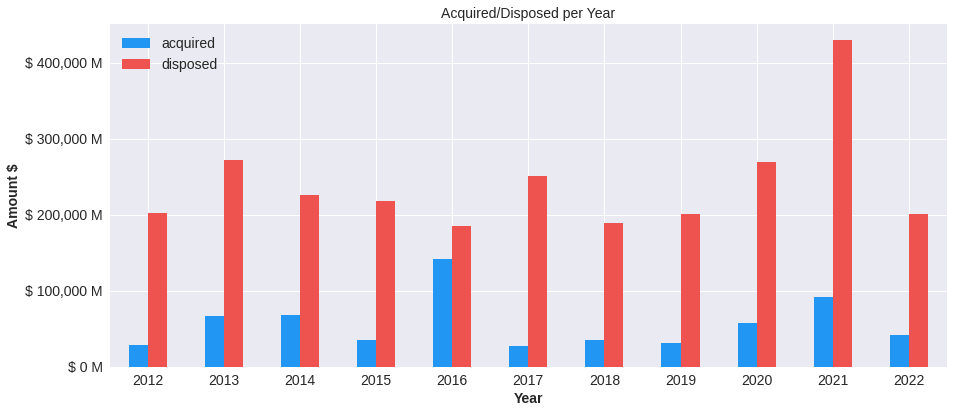

In [ ]:
plot_annual_graph(acquired_disposed_all)

# Distribution of Transaction Codes

Initially, we briefly covered transaction codes. The following code generates the distribution of such transaction codes measured against the total transaction volume. 

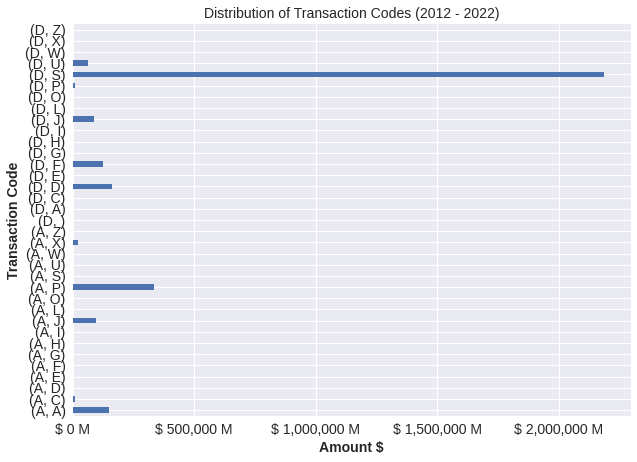

In [ ]:
transaction_code = all_trades\
    .groupby(["acquiredDisposed", "codingCode"])['total'] \
    .sum() 

ax_codes = transaction_code.plot.barh(figsize=(10,8))
ax_codes.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
ax_codes.set_xlabel("Amount $")
ax_codes.set_ylabel("Transaction Code")
ax_codes.set_title("Distribution of Transaction Codes (2012 - 2022)")
ax_codes.figure.autofmt_xdate(rotation=0, ha='center')

plt.show()

# Companies most often bought/sold in 2022

Let's determine the stocks that insider bought and sold the most in 2022.

The next part is used to get the total amount of trades acquired by ticker in 2022. It first creates a new column called `year_22`, which is a boolean value indicating whether the period of report (i.e. the date the transaction occurred) corresponds to 2022. Then it filters the `all_trades` dataframe based on the boolean value and whether `acquiredDisposed` is `A` (indicating whether it was acquired). The filtered dataframe is then grouped by `issuerTicker`, and the `total` sum for each ticker is calculated and sorted in descending order.

In [ ]:
year_22 = all_trades['periodOfReport'].dt.year == 2022

acquired_by_ticker = all_trades[(all_trades["acquiredDisposed"]=="A") & year_22] \
    .groupby(["issuerTicker"])['total'] \
    .sum() \
    .sort_values(ascending=False)

acquired_by_ticker.head(5)

issuerTicker
OXY     9002217384
IEP     2179778600
NLSN    1699968222
SC      1177306362
LCID     914999991
Name: total, dtype: object

In [ ]:
disposed_by_ticker = all_trades[(all_trades["acquiredDisposed"]=="D") & year_22] \
    .groupby(["issuerTicker"])['total'] \
    .sum() \
    .sort_values(ascending=False)

disposed_by_ticker.head(5)

issuerTicker
TSLA    23121540588
ANAT     9707035011
MCFE     9309015638
MSP      8715416238
STZ      5789917688
Name: total, dtype: object

The next part creates a figure with two subplots, each with a bar plot. The first plot shows the top 15 most bought companies in 2022 and the second plot shows the top 15 most sold companies in 2022.

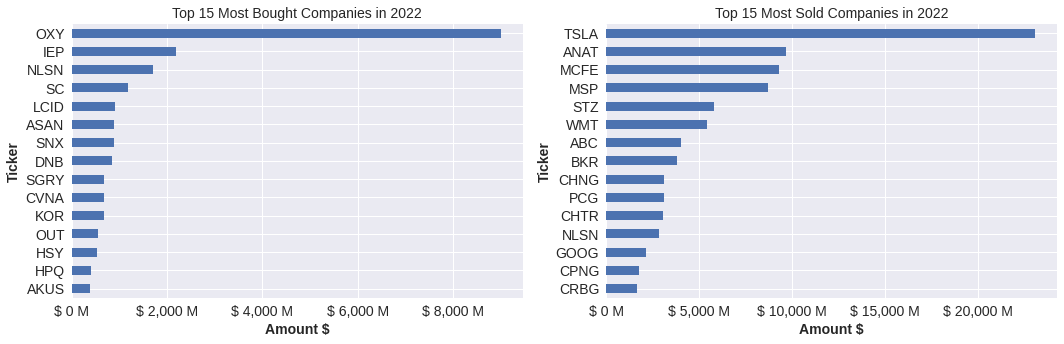

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax_ac_ti = acquired_by_ticker.head(15).sort_values(ascending=True).plot.barh(ax=axes[0], y='issuerTicker')
ax_ac_ti.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
ax_ac_ti.set_xlabel("Amount $")
ax_ac_ti.set_ylabel("Ticker")
ax_ac_ti.set_title("Top 15 Most Bought Companies in 2022")
ax_ac_ti.figure.autofmt_xdate(rotation=0, ha='center')

ax_di_ti = disposed_by_ticker.head(15).sort_values(ascending=True).plot.barh(ax=axes[1], y='issuerTicker')
ax_di_ti.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
ax_di_ti.set_xlabel("Amount $")
ax_di_ti.set_ylabel("Ticker")
ax_di_ti.set_title("Top 15 Most Sold Companies in 2022")
ax_di_ti.figure.autofmt_xdate(rotation=0, ha='center')

fig.tight_layout()

# Insiders that sold/bought the most in 2022

The next part deals with finding the top 10 largest sellers and buyers in 2022. Same as before, we create two dataframes, `acquired_by_insider` and `disposed_by_insider`, grouping by `reportingPerson` and `issuerTicker` and then summarizing the `total` transaction amounts per reporter and ticker.


In [ ]:
acquired_by_insider = all_trades[(all_trades["acquiredDisposed"]=="A") & year_22] \
    .groupby(["reportingPerson", "issuerTicker"])['total'] \
    .sum() \
    .sort_values(ascending=False)

acquired_by_insider.head(5)

reportingPerson           issuerTicker
BERKSHIRE HATHAWAY INC    OXY             9001419282
ICAHN CARL C              IEP             2179778600
WINDACRE PARTNERSHIP LLC  NLSN            1695976202
PUBLIC INVESTMENT FUND    LCID             914999991
Moskovitz Dustin A.       ASAN             885320147
Name: total, dtype: object

In [ ]:
disposed_by_insider = all_trades[(all_trades["acquiredDisposed"]=="D") & year_22] \
    .groupby(["reportingPerson", "issuerTicker"])['total'] \
    .sum() \
    .sort_values(ascending=False)

disposed_by_insider.head(5)

reportingPerson                      issuerTicker
Musk Elon                            TSLA            22934307944
Intel Americas, Inc.                 MCFE             4561417978
Vista Equity Partners Fund VI, L.P.  MSP              4038253333
VEP Group, LLC                       MSP              4038253333
Walgreens Boots Alliance, Inc.       ABC              3930130087
Name: total, dtype: object

In [ ]:
def name_formatter(tup):
  name, ticker = tup
  name = name[:30] + '..' if len(name) > 30 else name
  return (name, ticker)

acquired_by_insider.index = acquired_by_insider.index.map(name_formatter)
disposed_by_insider.index = disposed_by_insider.index.map(name_formatter)

acquired_by_insider.head(5)

reportingPerson           issuerTicker
BERKSHIRE HATHAWAY INC    OXY             9001419282
ICAHN CARL C              IEP             2179778600
WINDACRE PARTNERSHIP LLC  NLSN            1695976202
PUBLIC INVESTMENT FUND    LCID             914999991
Moskovitz Dustin A.       ASAN             885320147
Name: total, dtype: object

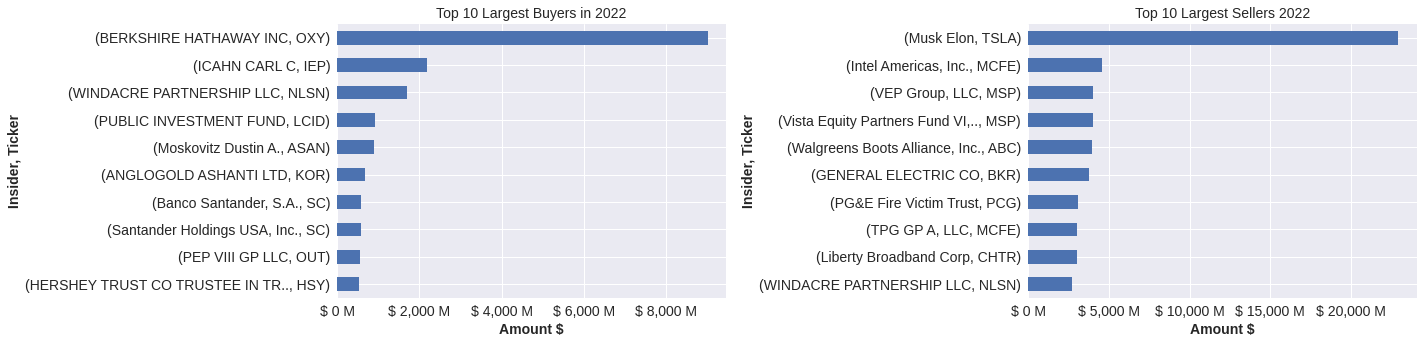

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

ax_ac_in = acquired_by_insider.head(10).sort_values(ascending=True).plot.barh(ax=axes[0], y='reportingPerson')
ax_ac_in.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
ax_ac_in.set_xlabel("Amount $")
ax_ac_in.set_ylabel("Insider, Ticker")
ax_ac_in.set_title("Top 10 Largest Buyers in 2022")
ax_ac_in.figure.autofmt_xdate(rotation=0, ha='center')

ax_di_in = disposed_by_insider.head(10).sort_values(ascending=True).plot.barh(ax=axes[1], y='reportingPerson')
ax_di_in.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
ax_di_in.set_xlabel("Amount $")
ax_di_in.set_ylabel("Insider, Ticker")
ax_di_in.set_title("Top 10 Largest Sellers 2022")
ax_di_in.figure.autofmt_xdate(rotation=0, ha='center')

fig.tight_layout()

# Buffet’s timing to buy OXY shares

In the next chapter we discuss how to overlay insider transactions onto a daily stock price chart. I used my brokers' API to generate daily price statistics for a security, save the data points to a CSV file and load the file from Google Drive into the dataframe `oxy_price`.

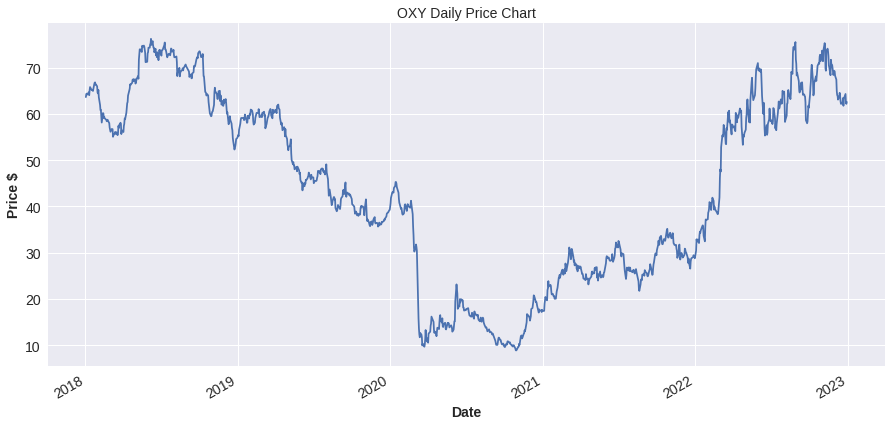

In [ ]:
oxy_price = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/insider-trading-monitor/OXY.csv')

oxy_price['date'] = pd.to_datetime(oxy_price['date'])

oxy_price = oxy_price[(oxy_price["date"]>=datetime(2018, 1, 1))]

oxy_price = oxy_price.set_index('date')

oxy_price["average"].plot(xlabel="Date", ylabel="Price $", title="OXY Daily Price Chart", figsize=(15,7))

The next part is creating a DataFrame containing the total amount of trades made by the Berkshire Hathaway on OXY securities since January 1st, 2018. The first line creates a filter for `all_trades`, specifying that it should only include trades from OXY securities acquired by “BERKSHIRE”. It then groups together these trades based on the `periodOfReport` column and sums up their total values. The index names are then changed to `date` and it is merged with the daily pricing DataFrame `oxy_price`, on date. Any `NaN` values are filled with `0`.

In [ ]:
oxy_filter = (all_trades["issuerTicker"]=="OXY") & \
  (all_trades["acquiredDisposed"]=="A") & \
  (all_trades["periodOfReport"]>=datetime(2018, 1, 1)) & \
  (all_trades["reportingPerson"].str.contains("BERKSHIRE"))

oxy_acquired = all_trades[oxy_filter].groupby("periodOfReport")["total"].sum()

oxy_acquired.index.names = ['date']

In [ ]:
oxy_all = pd.merge(oxy_price, oxy_acquired, on='date', how='outer').fillna(0)
oxy_all.head(5)

,Unnamed: 0,open,high,low,close,volume,average,barCount,total
date,,,,,,,,,
2018-01-02,1249,63.7175,63.9931,63.2868,63.7175,24267.99,63.656311,12481,0
2018-01-03,1250,63.6916,64.6907,63.6916,64.5960,31392.58,64.319496,16453,0
2018-01-04,1251,64.3806,64.5874,63.1060,64.5615,24332.43,64.414237,13160,0
2018-01-05,1252,64.4495,64.5701,63.9500,64.2084,28760.02,64.187720,15330,0
2018-01-08,1253,64.2515,64.8027,64.0878,64.7252,28326.58,64.594244,13440,0


The `print_chart()` function takes in two arguments: `ticker_series` and `title`. It creates a data visualization of the `ticker_series` and uses a for loop to draw markers onto the price time series, where the marker size correlates to insider transaction volume. Additionally, it draws an arrow pointer at the largest insider transaction. Finally, it prints the total $ amount of securities purchased at the middle of the graph.

In [ ]:
def print_chart(ticker_series, title="", ylabel="Price $"):
  ax = ticker_series["average"].plot(figsize=(18, 7))
  ax.xaxis_date()
  ax.plot(ticker_series.index, ticker_series['average'], lw=2)

  max_acquired = ticker_series['total'].max()

  # draw markers onto price time series. Marker size correlates to news volume.
  for index, row in ticker_series.iterrows():
    if row['total'] == 0:
      continue

    markersize = (row['total'] / max_acquired) * 25

    if markersize < 7:
      markersize = 7

    ax.plot([index], 
            [row['average']], 
            marker='o', 
            color='red', 
            markersize=markersize)
    
    # overlay arrow pointer at largest news volume 
    if row['total'] == max_acquired:
      ax.annotate(
        '\n' + "$ {:,.0f}".format(row['total']),
        xy=(index, row['average']), xycoords='data',
        xytext=(0, -30), textcoords='offset pixels',
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='red')
      )

  ax.set_ylabel(ylabel)
  ax.set_xlabel('Day')
  ax.set_title(title)

  total = ticker_series['total'].sum()
  text_y_pos = (ticker_series['average'].max() + ticker_series['average'].min()) / 2
  ax.annotate(
    'Total amount: ' + "$ {:,.0f}".format(total),
    xy=(ticker_series.index[10], text_y_pos), xycoords='data',
    xytext=(0, -30), textcoords='offset pixels',
  )

  plt.setp(plt.gca().get_xticklabels(), rotation = 0, ha='center')
  plt.show()

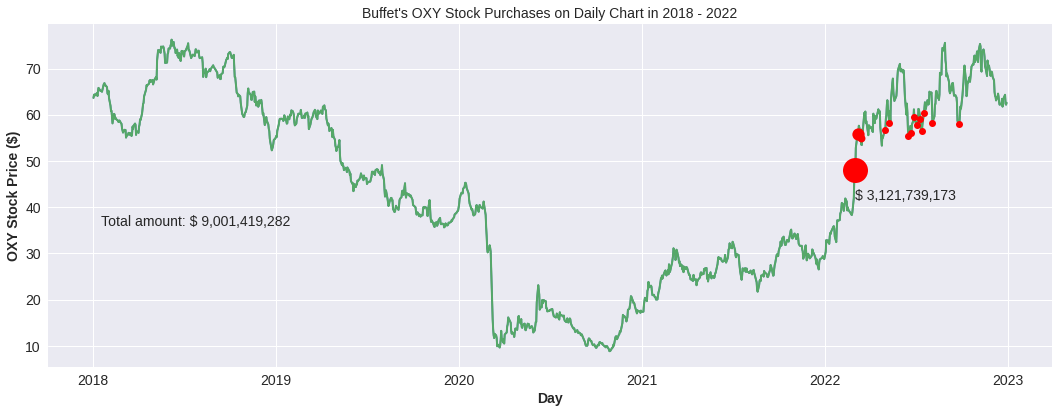

In [ ]:
print_chart(oxy_all, "Buffet's OXY Stock Purchases on Daily Chart in 2018 - 2022", "OXY Stock Price ($)")

Plotting Elon Musk’s insider sales onto Tesla’s daily price chart only requires adding an additional cleaning step.

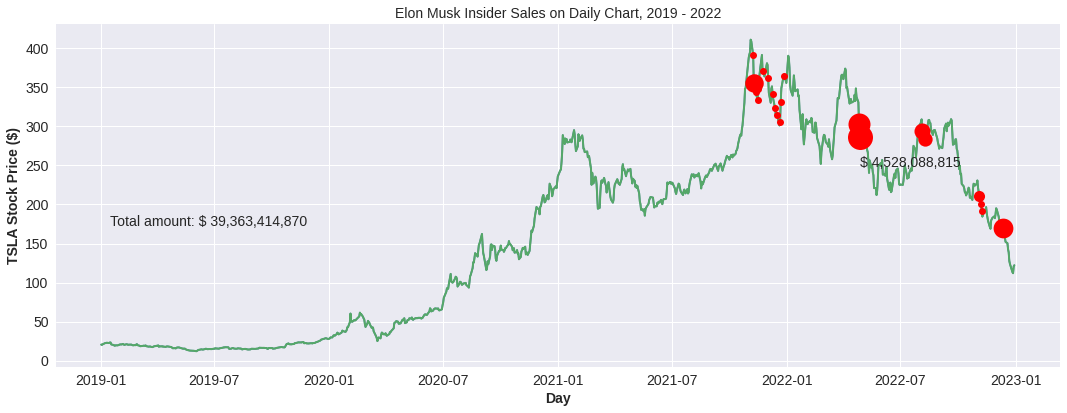

In [ ]:
import numpy as np 

tsla_price = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/insider-trading-monitor/TSLA.csv')
tsla_price['date'] = pd.to_datetime(tsla_price['date'])
tsla_price = tsla_price[(tsla_price["date"]>=datetime(2019, 1, 1))]
# remove one incorrect data point
tsla_index_filter = tsla_price[tsla_price['average'] > 700].index
tsla_price.drop(tsla_index_filter , inplace=True)
tsla_price = tsla_price.set_index('date')

tsla_filter = (all_trades["issuerTicker"]=="TSLA") & \
  (all_trades["acquiredDisposed"]=="D") & \
  (all_trades["periodOfReport"]>=datetime(2019, 1, 1)) & \
  (all_trades["reportingPerson"].str.contains("Elon"))

tsla_disposed = all_trades[tsla_filter].groupby("periodOfReport")["total"].sum()
tsla_disposed.index.names = ['date']
tsla_all = pd.merge(tsla_price, tsla_disposed, on='date', how='outer').fillna(0).sort_values(by='date')

# sometimes "periodfOfReport" represents a Saturday, but price data isn't available
# for such days because the market is closed. so, we forward-fill such values.
tsla_all['average'] = tsla_all['average'].replace(0, np.nan).ffill(axis ='rows')

print_chart(tsla_all, "Elon Musk Insider Sales on Daily Chart, 2019 - 2022", "TSLA Stock Price ($)")

# Sector statistics

Analyzing insider activity across sectors is the last chapter of this tutorial. We continue with creating a new dataframe called `sector_trades`, which is a copy of the `all_trades` dataframe. The new dataframe only includes the columns `sector`, `total`, `periodOfReport` and `acquiredDisposed`. It then filters out any rows that have an empty value in the `sector` column. The values in the column named `periodOfReport` are then converted to a datetime format and set as the index for `sector_trades`.

In [ ]:
sector_trades = all_trades[['sector', 'total', 'periodOfReport', 'acquiredDisposed']].copy()
sector_trades.head(4)
sector_trades = sector_trades[sector_trades["sector"] != ""]
sector_trades['periodOfReport'] = pd.to_datetime(sector_trades['periodOfReport'])
sector_trades = sector_trades.set_index('periodOfReport')
sector_trades.groupby([pd.Grouper(freq='Y'), "acquiredDisposed", "sector"]).head(5)

<ipython-input-42-bdd100419976>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sector_trades['periodOfReport'] = pd.to_datetime(sector_trades['periodOfReport'])


,sector,total,acquiredDisposed
periodOfReport,,,
2012-01-01,Healthcare,400,A
2012-01-01,Healthcare,160000000,A
2012-01-01,Consumer Defensive,5021,D
2012-01-01,Consumer Defensive,5999,D
2012-01-01,Consumer Defensive,5232,D
...,...,...,...
2022-01-03,Communication Services,15540,A
2022-01-03,Communication Services,500,A
2022-01-03,Communication Services,1042,A


Using pandas `unstack()` function allows us to create a more readable data structure for plotting stacked bar charts.

In [ ]:
sector_trades[sector_trades["acquiredDisposed"]=="D"] \
            .groupby([pd.Grouper(freq='Y'), "acquiredDisposed", "sector"])['total'] \
            .sum() \
            .unstack()

,sector,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
periodOfReport,acquiredDisposed,,,,,,,,,,,
2012-12-31,D,9797499803,5841613169,24313930860,21855654495,32262645372,21539322289,18339774792,18078101911,7259071745,37868902324,1887139505
2013-12-31,D,9251198777,1379323263,50673768601,12433221422,25585832669,16731183123,28216426306,33605753497,28344539618,62316234289,2410896762
2014-12-31,D,6952428451,344862044,51486625704,9603133258,25736540239,24251859251,28641252862,23701463753,8511269815,39073188114,2242659583
2015-12-31,D,10493968225,329041000,49852119363,12594359571,9574904953,23540742662,26156301322,14967833311,19737992753,49429648599,721955299
2016-12-31,D,20402432735,431522591,30850761629,14765560121,3577206387,12437303760,18014976383,23607444124,20809646963,39010897623,924300350
2017-12-31,D,11313355978,4595332721,57111728121,34576928677,5406339936,20908576139,20983164967,22814516598,14650227830,54425425358,2692218195
2018-12-31,D,4641168836,495554974,35363479655,20774715810,9907648898,21908413399,22368033594,15492289546,6079734918,50048301347,1674926374
2019-12-31,D,3153045914,1594606945,17057925218,18860556369,8142436611,17194705798,23591864177,13067263517,47028461060,49251583757,2161252957
2020-12-31,D,6093533153,20365184102,21757639421,26487618973,2200549069,28947189170,51076211231,16020141775,3564078627,82032267527,1536408671


The corresponding logic to plot the unstacked data is described in `print_sector_stats()`.

In [ ]:
def print_sector_stats(trades, title="Acquisition Distribution per Sector per Year"):
  df = trades.groupby([pd.Grouper(freq='Y'), "acquiredDisposed", "sector"])['total'].sum()

  fig, ax = plt.subplots()

  unstacked = df.unstack()
  unstacked.plot.bar(stacked=True, ax=ax, figsize=(17, 10))

  ax.legend(loc=2)

  ax.grid(True)
  ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
  ax.set_xticks(range(unstacked.index.size))
  ax.set_xticklabels([idx[0].strftime('%Y') for idx in unstacked.index])
  ax.figure.autofmt_xdate(rotation=0, ha='center')
  ax.set_xlabel("Year")
  ax.set_ylabel("Amount $")
  ax.set_title(title)

  plt.show()

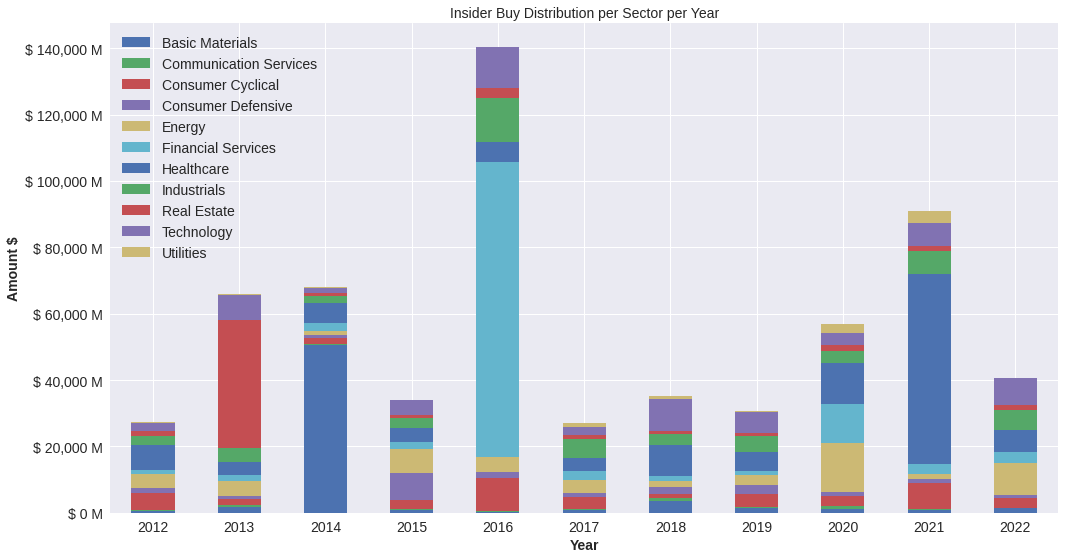

In [ ]:
print_sector_stats(sector_trades[sector_trades["acquiredDisposed"]=="A"], "Insider Buy Distribution per Sector per Year")

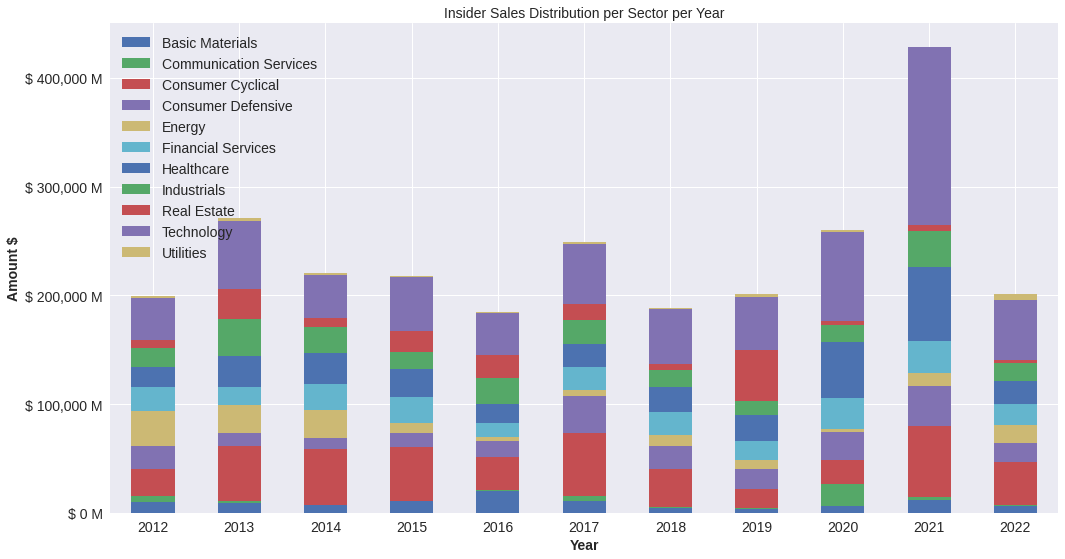

In [ ]:
print_sector_stats(sector_trades[sector_trades["acquiredDisposed"]=="D"], "Insider Sales Distribution per Sector per Year")

# Conclusion

Wow, if you stayed with me up until now, you’re truly interested in this topic. In summary, we learned how to access all insider transactions disclosed over the last decade and analyze the data using various techniques, such as daily chart overlay plots.

Keep in mind that the approach discussed has some weaknesses. For example, we ignored all derivative transactions in our analysis. Usually, derivative transactions include issuance of options with \$0 price tags attached. However, there might be some transactions with >$0 prices that we didn’t consider. Also, the price per share vs total amount of transaction discrepancy isn’t 100% solved. We would have to check the share price at each transaction date in order to ensure the correctness of the reported transaction price and, if necessary, convert the total price to its price per share equivalent. Also, a change of ticker symbol was not considered in our analysis. For example, an insider might disclose a Form 4 with ticker ABC, company ABC changes its ticker to XYZ, and insider discloses another Form 4 with ticker XYZ. The two disclosed transactions are not linked anymore and would be classified as one insider, trading two different stocks.

# Other Relevant Filings

- [Form 13D](https://www.ecfr.gov/current/title-17/chapter-II/part-240/section-240.13d-1#p-240.13d-1(a)) has to be filed 10 days after the acquisition of more than 5% ownership of the company. Person can choose to file Form 13G instead if no control over company is wanted.
- [Form 13G](https://www.ecfr.gov/current/title-17/chapter-II/part-240/section-240.13d-1#p-240.13d-1(b)(2)) has to be filed 45 days after the end of the calendar year and is intended for investors not wanting to change/influence the control of the company. For example, brokers, banks and investment adviers. If the ownership exceeds 10%, Form 13G has to be filed within 10 days after the month of acquisition. Person has to file Form 13D instead if ownership exceeds 20% or if person wants to control the company.
- [Form 13F](https://www.ecfr.gov/current/title-17/chapter-II/part-240/section-240.13f-1) is filed by institutional investment managers managing $100M+ AUM on a quarterly schedule, and discloses all holdings of the managers.

# Papers about insider trading

[SEC Rule 10b5-1 and insiders’ strategic trade](https://bradreese.com/blog/6-28-2012.pdf)

[Offensive Disclosure: How Voluntary Disclosure Can Increase Returns from Insider Trading](https://chicagounbound.uchicago.edu/cgi/viewcontent.cgi?article=12130&context=journal_articles)

[Decoding Inside Informatio](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1540-6261.2012.01740.x)

[Do SEC’s 10b5-1 Safe Harbor Rules Need To Be Rewritten?](https://journals.library.columbia.edu/index.php/CBLR/article/view/1734)

[SEC Rule 10b5-1 Plans and Strategic Trade around Earnings Announcements](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2880878)

[Insider sales based on short-term earnings information](https://ideas.repec.org/a/kap/rqfnac/v47y2016i1d10.1007_s11156-014-0496-7.html)

# References

- https://www.sec.gov/rules/other/34-46313.htm
- https://www.law.cornell.edu/cfr/text/17/240.16a-1
- https://www.law.cornell.edu/cfr/text/17/240.16a-2
- https://www.ecfr.gov/current/title-17/chapter-II/part-240/subject-group-ECFR4594b28bbb3a5d5/section-240.16a-2
- https://www.law.cornell.edu/uscode/text/15/78p
- https://www.law.cornell.edu/uscode/text/15/80a-29
- https://www.law.cornell.edu/cfr/text/17/240.16b-3
- https://www.investopedia.com/terms/s/section-16.asp
- https://www.investopedia.com/terms/s/shortswingprofitrule.asp
- https://www.sec.gov/divisions/corpfin/guidance/sec16interp
- https://www.law.cornell.edu/cfr/text/12/163.172
- https://www.cfainstitute.org/en/advocacy/issues/derivatives
- https://www.law.cornell.edu/cfr/text/17/240.10b-5
- https://www.ecfr.gov/current/title-17/chapter-II/part-240/subpart-A#240.10b-5
- https://www.sec.gov/rules/final/33-7881.htm
- https://www.akingump.com/en/news-insights/sec-amendments-regarding-rule-10b5-1-insider-trading-plans-and-related-disclosures.html
- https://www.federalregister.gov/documents/2022/12/29/2022-27675/insider-trading-arrangements-and-related-disclosures
- https://www.ecfr.gov/current/title-17/chapter-II/part-240/section-240.13d-101
- https://www.ecfr.gov/current/title-17/chapter-II/part-240/section-240.13d-102
- https://www.ecfr.gov/current/title-17/chapter-II/part-240/section-240.13d-1#p-240.13d-1(a)
- https://www.law.cornell.edu/cfr/text/17/240.16a-13



